In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import tensorflow as tf
from tensorflow.keras import layers, models
import time
no = "2"
dataPath = "/content/drive/MyDrive/Colab Notebooks/project2/data/nifti"
# example_filename = os.path.join(data_path, 'example4d.nii.gz')
img1 = nib.load('{}/{}/image.nii.gz'.format(dataPath, no))
img2 = nib.load('{}/{}/mask.nii.gz'.format(dataPath, no))
xn = img1.shape[0]
yn = img1.shape[1]
zn = img1.shape[2]
imgs = { }
def readFile(no):
    global imgs, dataPath
    # example_filename = os.path.join(data_path, 'example4d.nii.gz')
    img1 = nib.load('{}/{}/image.nii.gz'.format(dataPath, no))
    img2 = nib.load('{}/{}/mask.nii.gz'.format(dataPath, no))
    xn = img1.shape[0]
    yn = img1.shape[1]
    zn = img1.shape[2]
    dImg = img1.get_data()
    dMask = img2.get_data()
    
    f = open('{}/{}/ranges.txt'.format(dataPath, no), "r")
    lines = f.readlines()
    valRange = [float(i) for i in (lines[0].split("(")[1].split(")")[0].split(" to "))]
    bounds = lines[1].split("; ")
    xs = [int(i) for i in bounds[0].split(": ")[1].split(")")[0].split(", ")]
    ys = [int(i) for i in bounds[1].split(": ")[1].split(")")[0].split(", ")]
    zs = [int(i) for i in bounds[2].split(": ")[1].split(")")[0].split(", ")]
    return { 'xn': xn, 'yn': yn, 'zn': zn, 'dImg': dImg, 'dMask': dMask, 'x0': xs[0], 'x1': xs[1], 'y0': ys[0], 'y1': ys[1], 'b': zs[0], 't': zs[1], 'z0': zs[0], 'z1': zs[1], 'width': xs[1] - xs[0], 'height': ys[1] - ys[0], 'depth': zs[1] - zs[0], "val0": valRange[0], "val1": valRange[1] }

In [5]:
def readImgBound(no):
    global dataPath
    f = open('{}/{}/ranges.txt'.format(dataPath, no), "r")
    lines = f.readlines()
    valRange = [float(i) for i in (lines[0].split("(")[1].split(")")[0].split(" to "))]
    bounds = lines[1].split("; ")
    xs = [int(i) for i in bounds[0].split(": ")[1].split(")")[0].split(", ")]
    ys = [int(i) for i in bounds[1].split(": ")[1].split(")")[0].split(", ")]
    zs = [int(i) for i in bounds[2].split(": ")[1].split(")")[0].split(", ")]
    return { 'x0': xs[0], 'x1': xs[1], 'y0': ys[0], 'y1': ys[1], 'b': zs[0], 't': zs[1], 'z0': zs[0], 'z1': zs[1], 'width': xs[1] - xs[0], 'height': ys[1] - ys[0], 'depth': zs[1] - zs[0], "val0": valRange[0], "val1": valRange[1] }

In [ ]:
allBounds = { }
def readBoundAndShow():
    global allBounds
    print("w, h, d")
    w = 0
    h = 0
    d = 0
    for i in range(1, 101):
        bound = readImgBound(i)
        print("{}, {}, {}".format(bound["width"], bound["height"], bound["depth"]))
        if w < bound["width"]:
            w = bound["width"]
        if h < bound["height"]:
            h = bound["height"]
        if d < bound["depth"]:
            d = bound["depth"]
    print("max: {}, {}, {}".format(w, h, d))
    allBounds["w"] = w
    allBounds["h"] = h
    allBounds["d"] = d
readBoundAndShow()

In [6]:
allBounds = {'w': 128, 'h': 128, 'd': 195}

In [7]:
def printImg(img):
    plt.imshow(img)
    plt.show()

In [7]:
def getImg(z, y0 = 0, y1 = yn, x0 = 0, x1 = xn, dataConstant = True, vLow = 120, vHigh = 2000, ds = [ ], minValue = -2000, maxValue = 0):
    data = [ ]
    for y in range(y0, y1):
        dy = [ ]
        for x in range(x0, x1):
            if ds[x][y][z] > vLow and ds[x][y][z] < vHigh:
                if dataConstant:
                    dy.append(maxValue)
                else:
                    dy.append(ds[x][y][z])
            else:
                dy.append(minValue)
        data.append(dy)
    # print(maxValue)
    return data
def getImgBound(imgNo = 2, z = 0, dataConstant = True, vLow = 120, vHigh = 2000, ds = 'dImg', minValue = -2000, maxValue = 0):
    global imgs, allBounds
    if str(imgNo) not in imgs:
        imgs = { }
        imgs[str(imgNo)] = readFile(imgNo)
    imgBound = imgs[str(imgNo)]
    x0 = imgBound["x0"]
    x1 = imgBound["x1"]
    y0 = imgBound["y0"]
    y1 = imgBound["y1"]
    # if imgBound["width"] < allBounds["w"]:
    x0 = x0 - int((allBounds["w"] - imgBound["width"]) / 2)
    x1 = x0 + allBounds["w"]
    # if imgBound["height"] < allBounds["h"]:
    y0 = y0 - int((allBounds["h"] - imgBound["height"]) / 2)
    y1 = y0 + allBounds["h"]
    # print("x0: {}, x1: {}, y0: {}, y1: {}".format(x0, x1, y0, y1))
    return getImg(imgBound["b"] + z, y0, y1, x0, x1, dataConstant, vLow, vHigh, imgBound[ds], minValue, maxValue)
def getModelImgs(no, z, model):
    imgs = [ ]
    imgs.append(getImgBound(no, z, False, -2000, 2000, 'dImg'))
    imgs = np.array(imgs)
    imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2], 1))
    overlapC = model2.predict(imgs)[0]
    
    imgD = getImgBound(no, z, False, -250, 250, 'dImg', -500, 500)
    for i in range(len(imgD)):
        for j in range(len(imgD[i])):
            if imgD[i][j] >= -250 and imgD[i][j] <= 250 and overlapC[int((imgD[i][j] + 250) / 5)] == 1:
                imgD[i][j] = 400
            elif imgD[i][j] >= -250 and imgD[i][j] <= 250:
                imgD[i][j] = -400
            elif imgD[i][j] < -250:
                imgD[i][j] = -400
            elif imgD[i][j] > 250:
                imgD[i][j] = 400
    # overlapC = [(0 if maskC * percent / 100 <= i else 1, maskC, i) for i in overlapC]
    # overlapC = [(0 if maskC * percent / 100 <= i else 1) for i in overlapC]
    return imgD
def getAllImgs(no, z = -1):
    global dataPath
    imgs = [ ]
    zBegin = z
    zEnd = z + 1
    if z == -1:
        zBegin = 2
        zEnd = readImgBound(no)["depth"]
    imgs = [ ]
    for z in range(zBegin, zEnd):
        imgs.append(getImgBound(no, z, False, -2000, 2000, 'dImg'))
    imgs = np.array(imgs)
    # print(imgs.shape)
    imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2], 1))
    # np.save("{}/0_range/{}-{}-3_128".format(dataPath, noFrom, noTo), imgs)
    return imgs
def getAllYVals(noFrom, noTo):
    imgs = [ ]
    for no in range(noFrom, noTo):
        for z in range(2, readImgBound(no)["depth"]):
            imgs.append(getImgBound(no, z, True, 1, 4, 'dMask', 0, 1))
        print(no)
    imgs = np.array(imgs)
    # print(imgs.shape)
    imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2], 1))
    # np.save("{}/0_range/{}-{}-skip-2-y_128".format(dataPath, noFrom, noTo), imgs)
    return imgs

In [8]:
def findEdge(img, imgBound, neighRange):
    def getNeighbourImg(imgBound, arr):
        img = [ [ 0 for i in range(imgBound["w"])] for j in range(imgBound["h"]) ]
        for i in arr:
            try:
                img[i[1]][i[0]] = 1
            except:
                print(i, imgBound, imgBound["w"], imgBound["h"])
        return img
    def isNeighbour2(img, x, y, val2, imgBound):
        c = 0
        cx = 0
        cy = 0
        for ty in range(-neighRange, neighRange + 1):
            for tx in range(-neighRange, neighRange + 1):
                if x + tx >= 0 and y + ty >= 0 and x + tx < imgBound["w"] and y + ty < imgBound["h"] and img[y + ty][x + tx] == val2:
                    c = c + 1
                    cx = tx
                    cy = ty
                    break
        return (True, cx, cy) if c > 0 else (False, cx, cy)
    def getNeighbour(img, arr, x, y, val1, val2, imgBound):
        c = 0
        for ty in range(-neighRange, neighRange + 1):
            for tx in range(-neighRange, neighRange + 1):
                if x + tx >= 0 and y + ty >= 0 and x + tx < imgBound["w"] and y + ty < imgBound["h"] and img[y + ty][x + tx] == val1 and isNeighbour2(img, x + tx, y + ty, val2, imgBound)[0]:
                    arr.append((x + tx, y + ty))
                    c = c + 1
        return c
    def markPoint(img, x, y, markValue, neighVal, imgBound):
        xStart = -1 if neighVal[1] == 0 else 0
        xEnd = 1 if neighVal[1] == 0 else 2 * neighVal[1]
        xStep = 1 if neighVal[1] == 0 else neighVal[1]
        yStart = -1 if neighVal[2] == 0 else 0
        yEnd = 1 if neighVal[2] == 0 else 2 * neighVal[2]
        yStep = 1 if neighVal[2] == 0 else neighVal[2]
        # print(xStart, xEnd, xStep, yStart, yEnd, yStep, markValue)
        for ty in range(yStart, yEnd, yStep):
            for tx in range(xStart, xEnd, xStep):
                if x + tx >= 0 and y + ty >= 0 and x + tx < imgBound["w"] and y + ty < imgBound["h"]:
                    img[y + ty][x + tx] = markValue
    def markEdge(img, x, y, imgBound, currentVal, markValue, neighVal):
        arr = [(x, y)]
        c = 1
        while len(arr) > 0:
            f = arr.pop()
            markPoint(img, f[0],  f[1], markValue, neighVal, imgBound)
            c = c + getNeighbour(img, arr, f[0], f[1], currentVal, 10, imgBound)
            # print
            # plt.imshow(img)
            # plt.show()
            # print(img(arr[-1][1], arr[-1][0]))
            # print(img[arr[-1][1]][arr[-1][0]])
            # plt.imshow(getNeighbourImg(imgBound, arr))
            # plt.show()
            # time.sleep(2)
        return img
    for y in range(imgBound["h"]):
        for x in range(imgBound["w"]):
            neighVal = isNeighbour2(img, x, y, 10, imgBound)
            if img[y][x] == -10 and neighVal[0] == True:
                # print(neighVal)
                timg = markEdge(img, x, y, imgBound, -10, -20, neighVal)
                # plt.imshow(timg)
                # plt.show()
                # time.sleep(4)
                # reg = markSmallRegions(img, x, y, -10, -8, imgBound)
    return img
def resetImg(img, imgBound):
    for y in range(imgBound["h"]):
        for x in range(imgBound["w"]):
            if img[y][x] == -20:
                img[y][x] = 10
    return img
def setMarksInImg(img, markedImg, imgBound):
    for y in range(imgBound["h"]):
        for x in range(imgBound["w"]):
            if markedImg[y][x] == -20:
                img[y][x] = -20
    return img
def revalueImg(img, imgBound):
    for y in range(imgBound["h"]):
        for x in range(imgBound["w"]):
            if img[y][x] == -10:
                img[y][x] = 0
            elif img[y][x] == 10:
                img[y][x] = 2
            else:
                img[y][x] = 1
    return img
def getBorderImg(no, z):
    tImgD = getImgBound(no, z, True, 1, 4, 'dMask', -10, 10)
    tImgD2 = getImgBound(no, z, True, 1, 4, 'dMask', -10, 10)
    tImgD = findEdge(tImgD, allBounds, 1)
    setMarksInImg(tImgD2, tImgD, allBounds)
    resetImg(tImgD, allBounds)
    return revalueImg(findEdge(tImgD, allBounds, 2), allBounds)
def getAllBorderYVals(no, z = -1):
    global dataPath
    zBegin = z
    zEnd = z + 1
    if z == -1:
        zBegin = 2
        zEnd = readImgBound(no)["depth"]
    imgs = [ ]
    for z in range(zBegin, zEnd):
        imgs.append(getBorderImg(no, z))
    imgs = np.array(imgs)
    # print(imgs.shape)
    imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2], 1))
    # np.save("{}/0_range/{}-{}-skip-3-y_128".format(dataPath, noFrom, noTo), imgs)
    return imgs

In [9]:
def createModel():
    # state
    lastInit = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    # input layer
    inputLayer = layers.Input(shape=([allBounds["h"], allBounds["w"], 1]))
    # hidden layer
    hiddenLayer = layers.Conv2D(32, (3, 3), activation="relu")(inputLayer)
    hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    hiddenLayer = layers.Flatten()(hiddenLayer)
    hiddenLayer = layers.Dense(200, activation="relu")(hiddenLayer)
    # output layer
    outputLayer = layers.Dense(100, activation="sigmoid", kernel_initializer=lastInit)(hiddenLayer)
    outputLayer = outputLayer * 1
    model = tf.keras.Model(inputLayer, outputLayer)
    return model
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x
def build_unet_model(inX, inY):
    # inputs
    inputs = layers.Input(shape=(inX, inY, 1))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
unet_model = build_unet_model(128, 128)
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
unet_model.load_weights("{}/0_range/model_{}-3_128".format(dataPath, 100))
unet_modelO2 = build_unet_model(128, 128)
unet_modelO2.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
unet_modelO2.load_weights("{}/0_range/organ2/model_{}-skip0-_128_border".format(dataPath, 100))
# second model
def build_unet_model2(inX, inY):
    # inputs
    inputs = layers.Input(shape=(inX, inY, 3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
unet_model2 = build_unet_model2(128, 128)
unet_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
unet_model2.load_weights("{}/0_range/model_{}-3x3-boundary-out_128".format(dataPath, 100))

In [ ]:
noStart = 80
noEnd = 100

In [ ]:
imgDSkip2Pred2 = np.load("{}/0_range/{}-{}-3-pred-layer2x3-y_128.npy".format(dataPath, noStart, noEnd))
imgDSkip2Pred2.shape

(640, 128, 128, 3)

In [ ]:
imgYSkip2Border = np.load("{}/0_range/{}-{}-skip-3-y_128.npy".format(dataPath, noStart, noEnd))
imgYSkip2Border.shape

(640, 128, 128, 1)

In [ ]:
imgYPred = unet_model2.predict(imgDSkip2Pred2)
imgYPred.shape

(640, 128, 128, 3)

In [10]:
def getRatio(img1, img2):
    img3 = img2.copy()
    img3 = img3[:, :, 2]
    c1 = 0
    c2 = 0
    for i in range(128):
        for j in range(128):
            if img1[i][j] > 0:
                c1 = c1 + 1
            if img1[i][j] > 0 and img3[i][j] < 0.1:
                img3[i][j] = 1
                c2 = c2 + 1
            else:
                img3[i][j] = 0
    t = 0
    if c1 > 0:
        t = c2 / c1
    if t <= 0.3:
        img3 = np.zeros((128, 128))
    return img3

In [ ]:
tImgs = [ ]
for i in range(imgYPred.shape[0]):
    # printImg(imgYSkip2Border[i].reshape((128, 128)))
    t = getRatio(imgYSkip2Border[i].reshape((128, 128)), imgYPred[i])
    tImgs.append(t)
    # printImg(t)
    print(i)
tImgs = np.array(tImgs)
tImgs = tImgs.reshape((tImgs.shape[0], 128, 128, 1))
print(tImgs.shape)
printImg(tImgs[78].reshape((128, 128)))
np.save("{}/0_range/{}-{}-skip2-wrongs1-y_128.npy".format(dataPath, noStart, noEnd), tImgs)

In [ ]:
def createModel():
    # state
    lastInit = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    # input layer
    inputLayer = layers.Input(shape=([allBounds["h"], allBounds["w"], 1]))
    # hidden layer
    hiddenLayer = layers.Conv2D(32, (3, 3), activation="relu")(inputLayer)
    hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    hiddenLayer = layers.Flatten()(hiddenLayer)
    hiddenLayer = layers.Dense(200, activation="relu")(hiddenLayer)
    # output layer
    outputLayer = layers.Dense(100, activation="sigmoid", kernel_initializer=lastInit)(hiddenLayer)
    outputLayer = outputLayer * 1
    model = tf.keras.Model(inputLayer, outputLayer)
    return model
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x
def build_unet_model(inX, inY):
    # inputs
    inputs = layers.Input(shape=(inX, inY, 3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
unet_model_wrong = build_unet_model(128, 128)
unet_model_wrong.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
unet_model_wrong.summary()

In [ ]:
noStart = 40
noEnd = 80

In [ ]:
imgD = np.load("{}/0_range/{}-{}-3-pred-layer2x3-y_128.npy".format(dataPath, noStart, noEnd))
imgD.shape

(1060, 128, 128, 3)

In [ ]:
imgY = np.load("{}/0_range/{}-{}-skip2-wrongs1-y_128.npy".format(dataPath, noStart, noEnd))
imgY.shape

(1060, 128, 128, 1)

In [ ]:
res = unet_model_wrong.fit(imgD, imgY, epochs=28)

Epoch 1/28
50/50 [==============================] - 29s 581ms/step - loss: 0.0735 - accuracy: 0.9929
Epoch 2/28
50/50 [==============================] - 22s 443ms/step - loss: 0.0702 - accuracy: 0.9929
Epoch 3/28
50/50 [==============================] - 22s 446ms/step - loss: 0.0683 - accuracy: 0.9929
Epoch 4/28
50/50 [==============================] - 22s 446ms/step - loss: 0.0599 - accuracy: 0.9928
Epoch 5/28
50/50 [==============================] - 22s 447ms/step - loss: 0.0547 - accuracy: 0.9929
Epoch 6/28
50/50 [==============================] - 22s 449ms/step - loss: 0.0500 - accuracy: 0.9928
Epoch 7/28
50/50 [==============================] - 23s 450ms/step - loss: 0.0481 - accuracy: 0.9930
Epoch 8/28
50/50 [==============================] - 23s 452ms/step - loss: 0.0453 - accuracy: 0.9930
Epoch 9/28
50/50 [==============================] - 23s 452ms/step - loss: 0.0414 - accuracy: 0.9930
Epoch 10/28
50/50 [==============================] - 23s 452ms/step - loss: 0.0391 - accura

In [ ]:
unet_model_wrong.save("{}/0_range/model_{}-3x2-wrong_128".format(dataPath, 100))

check model

In [ ]:
def createModel():
    # state
    lastInit = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    # input layer
    inputLayer = layers.Input(shape=([allBounds["h"], allBounds["w"], 1]))
    # hidden layer
    hiddenLayer = layers.Conv2D(32, (3, 3), activation="relu")(inputLayer)
    hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    hiddenLayer = layers.Flatten()(hiddenLayer)
    hiddenLayer = layers.Dense(200, activation="relu")(hiddenLayer)
    # output layer
    outputLayer = layers.Dense(100, activation="sigmoid", kernel_initializer=lastInit)(hiddenLayer)
    outputLayer = outputLayer * 1
    model = tf.keras.Model(inputLayer, outputLayer)
    return model
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x
def build_unet_model(inX, inY):
    # inputs
    inputs = layers.Input(shape=(inX, inY, 1))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
unet_model = build_unet_model(128, 128)
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
unet_model.load_weights("{}/0_range/model_{}-3_128".format(dataPath, 100))
unet_modelO2 = build_unet_model(128, 128)
unet_modelO2.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
unet_modelO2.load_weights("{}/0_range/organ2/model_{}-skip0-_128_border".format(dataPath, 100))
# second model
def build_unet_model2(inX, inY):
    # inputs
    inputs = layers.Input(shape=(inX, inY, 3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
unet_model2 = build_unet_model2(128, 128)
unet_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
unet_model2.load_weights("{}/0_range/model_{}-3x3-boundary-out_128".format(dataPath, 100))
# wrong model
def build_unet_model_wrong(inX, inY):
    # inputs
    inputs = layers.Input(shape=(inX, inY, 3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
unet_model_wrong = build_unet_model_wrong(128, 128)
unet_model_wrong.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
unet_model_wrong.load_weights("{}/0_range/model_{}-3x2-wrong_128".format(dataPath, 100))

In [9]:
def getIndices(noStart, noEnd):
    inds = [ ]
    imgY = np.load("{}/0_range/{}-{}-skip2-wrongs1-y_128.npy".format(dataPath, noStart, noEnd))
    for i in range(imgY.shape[0]):
        t = imgY[i].reshape((128 * 128))
        for j in t:
            if j == 1:
                inds.append(i)
                break
    return inds
inds = 0
imgD = 0
imgY = 0
imgPred = 0
imgPredWrong = 0
def getAllTestData(noStart, noEnd):
    global inds, imgD, imgY, imgPred, imgPredWrong
    inds = getIndices(noStart, noEnd)
    imgD = np.load("{}/0_range/{}-{}-3-pred-layer2x3-y_128.npy".format(dataPath, noStart, noEnd))
    print("imgD", imgD.shape)
    imgY = np.load("{}/0_range/{}-{}-skip2-wrongs1-y_128.npy".format(dataPath, noStart, noEnd))
    print("imgY", imgY.shape)
    imgPred = unet_model2.predict(imgD)
    print("imgPred", imgPred.shape)
    imgPredWrong = unet_model_wrong.predict(imgD)
    print("imgPredWrong", imgPredWrong.shape)
def printWrongs(noStart, noEnd):
    global inds, imgD, imgY, imgPred, imgPredWrong
    getAllTestData(noStart, noEnd)
    for i in inds:
        printImg(imgY[i].reshape((128, 128)))
        printImg(imgPred[i].reshape((128, 128, 3)))
        tImg = imgPredWrong[i].copy()
        tImg = tImg[:, :, 1]
        tImg = tImg.reshape((128, 128))
        printImg(tImg)
        print("------", i)
printWrongs(1, 11)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def getPred(dFrom, dTo, v):
    for i in range(128):
        for j in range(128):
            dTo[i][j][0] = dFrom[i][j][v]
def getPredY3(dFrom1, dFrom2, dFrom3, dTo):
    for i in range(128):
        for j in range(128):
            dTo[i][j][0] = dFrom1[i][j][0]
            dTo[i][j][1] = dFrom2[i][j][0]
            dTo[i][j][2] = dFrom3[i][j][0]
def getAllBorderInpVals(no, z = -1):
    global dataPath
    zBegin = z
    zEnd = z + 1
    if z == -1:
        zBegin = 2
        zEnd = readImgBound(no)["depth"]
    imgs = [ ]
    for z in range(zBegin, zEnd):
        imgt = np.array(getImgBound(no, z - 2, False, -2000, 2000, 'dImg'))
        imgt = imgt.reshape((1, 128, 128, 1))
        imgTestMask = unet_model.predict(imgt)[0]
        imgTestMask1 = np.array([0.0 for i in range(128 * 128)])
        imgTestMask1 = imgTestMask1.reshape((128, 128, 1))
        getPred(imgTestMask, imgTestMask1, 2)
        imgTestMask1 = imgTestMask1.reshape((128, 128, 1))

        imgt = np.array(getImgBound(no, z - 1, False, -2000, 2000, 'dImg'))
        imgt = imgt.reshape((1, 128, 128, 1))
        imgTestMask = unet_model.predict(imgt)[0]
        imgTestMask2 = np.array([0.0 for i in range(128 * 128)])
        imgTestMask2 = imgTestMask2.reshape((128, 128, 1))
        getPred(imgTestMask, imgTestMask2, 2)
        imgTestMask2 = imgTestMask2.reshape((128, 128, 1))

        imgt = np.array(getImgBound(no, z, False, -2000, 2000, 'dImg'))
        imgt = imgt.reshape((128, 128, 1))
        imgTestMask3 = np.array([0.0 for i in range(128 * 128 * 3)])
        imgTestMask3 = imgTestMask3.reshape((128, 128, 3))
        getPredY3(imgTestMask1, imgTestMask2, imgt, imgTestMask3)
        imgs.append(imgTestMask3)
    imgs = np.array(imgs)
    # print(imgs.shape)
    imgs = imgs.reshape((imgs.shape[0], 128, 128, 3))
    return imgs

In [ ]:
def sharpPred(data1, data2, x, y):
    nD11 = data1.copy()
    nD11 = nD11[:,:,2]
    nD12 = data1.copy()
    nD12 = nD12[:,:,1]

    nD21 = data2.copy()
    nD21 = nD21[:,:,2]
    nD22 = data2.copy()
    nD22 = nD22[:,:,1]
    for i in range(128):
        for j in range(128):
            if nD11[i][j] > x:
                nD11[i][j] = 2
            elif nD12[i][j] > y:
                nD11[i][j] = 1
            else:
                nD11[i][j] = 0
            # if nD11[i][j] == 0 and nD21[i][j] > x:
            #     nD11[i][j] = 4
            # elif nD11[i][j] == 0 and nD22[i][j] > y:
            #     nD11[i][j] = 3
    return nD11
def sharpPredAll(data1, data2, x, y):
    imgs = [ ]
    for i in range(len(data1)):
        imgs.append(sharpPred(data1[i], data2[i], x, y))
    imgs = np.array(imgs)
    return imgs.reshape((imgs.shape[0], 128, 128))

In [ ]:
def writeFile(fileName, scalarDataName, imgDataV):
    data = '''# vtk DataFile Version 2.0\nVolume organ\nASCII\nDATASET STRUCTURED_POINTS\nDIMENSIONS {} {} {}\nASPECT_RATIO 0.93 0.93 5\nORIGIN 0 0 0\nPOINT_DATA {}\nSCALARS {} float 1\nLOOKUP_TABLE default\n'''.format(imgDataV.shape[2], imgDataV.shape[1], imgDataV.shape[0], imgDataV.shape[2] * imgDataV.shape[1] * imgDataV.shape[0], scalarDataName)
    tD = [0 for i in range(imgDataV.shape[2] * imgDataV.shape[1] * imgDataV.shape[0])]
    tN = 0
    tVN = 0
    for z in range(imgDataV.shape[0]):
        for y in range(imgDataV.shape[1]):
            for x in range(imgDataV.shape[2]):
                tD[tN] = "{:.2f}".format(imgDataV[z][y][x])
                tN = tN + 1
    data = data + " ".join(tD)
    f = open("{}/0_range/3DViews/{}-{}.vtk".format(dataPath, fileName, scalarDataName), "w")
    f.write(data)
    f.close()

In [ ]:
imgD0 = 0
imgPred0 = 0
imgD = 0
imgPred = 0
imgPredO2 = 0
imgPredSharp = 0
imgY = 0
def getAllDataImg(no):
    global imgD0, imgPred0, imgD, imgPred, imgPredO2, imgPredSharp, imgY
    imgD0 = getAllImgs(no)
    print("imgD0 done", imgD0.shape)
    imgPred0 = unet_model.predict(imgD0)
    print("imgPred0 done", imgPred0.shape)
    imgD = getAllBorderInpVals(no)
    print("imgD done", imgD.shape)
    imgPred = unet_model2.predict(imgD)
    print("imgPred done", imgPred.shape)
    imgPredO2 = unet_modelO2.predict(imgD0)
    print("imgPredO2 done", imgPredO2.shape)
    imgPredSharp = sharpPredAll(imgPred, imgPredO2, 0.4, 0.3)
    print("imgPredSharp done", imgPredSharp.shape)
    imgY = getAllBorderYVals(no)
    print("imgY done", imgY.shape)
def saveAllDataImg(no):
    global imgD, imgPred, imgPredSharp, imgY
    writeFile(no, "pred-sharp", imgPredSharp)
    writeFile(no, "real-border", imgY.reshape((imgY.shape[0], 128, 128)))

In [ ]:
getAllDataImg(107)

imgD0 done (36, 128, 128, 1)


In [ ]:
saveAllDataImg(102)

In [ ]:
for i in range(103, 115):
    getAllDataImg(i)
    saveAllDataImg(i)

In [ ]:
imgD = getAllBorderInpVals(101)
imgD.shape

In [ ]:
printImg(imgD[0])

In [ ]:
imgPred = unet_model2.predict(imgD)
imgPred.shape

(35, 128, 128, 3)

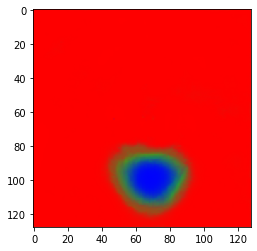

In [ ]:
printImg(imgPred[0])

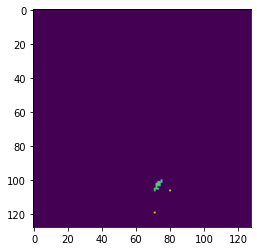

In [ ]:
nn = 23
printImg(sharpPred(imgPred[nn], imgPredO2[nn], 0.4, 0.3))

In [ ]:
imgPredSharp = sharpPredAll(imgPred, 0.4, 0.3)
imgPredSharp.shape

In [ ]:
for i in range(imgPred0.shape[0]):
    # printImg(imgY[i].reshape((128, 128)))
    printImg(imgPred0[i])
    printImg(imgPredO2[i])
    print(i)

In [ ]:
writeFile("101-0", "pred-sharp", imgPredSharp)

In [ ]:
writeFile("101-0", "real-border", imgY.reshape((imgY.shape[0], 128, 128)))

In [ ]:
imgY = getAllBorderYVals(101)
imgY.shape

(35, 128, 128, 1)

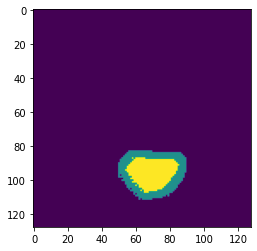

In [ ]:
printImg(imgY[0].reshape((128, 128)))

In [ ]:
imgD = getAllYVals(80, 100)
imgD.shape

In [ ]:
def findEdge(img, imgBound, neighRange):
    def getNeighbourImg(imgBound, arr):
        img = [ [ 0 for i in range(imgBound["w"])] for j in range(imgBound["h"]) ]
        for i in arr:
            try:
                img[i[1]][i[0]] = 1
            except:
                print(i, imgBound, imgBound["w"], imgBound["h"])
        return img
    def isNeighbour2(img, x, y, val2, imgBound):
        c = 0
        cx = 0
        cy = 0
        for ty in range(-neighRange, neighRange + 1):
            for tx in range(-neighRange, neighRange + 1):
                if x + tx >= 0 and y + ty >= 0 and x + tx < imgBound["w"] and y + ty < imgBound["h"] and img[y + ty][x + tx] == val2:
                    c = c + 1
                    cx = tx
                    cy = ty
                    break
        return (True, cx, cy) if c > 0 else (False, cx, cy)
    def getNeighbour(img, arr, x, y, val1, val2, imgBound):
        c = 0
        for ty in range(-neighRange, neighRange + 1):
            for tx in range(-neighRange, neighRange + 1):
                if x + tx >= 0 and y + ty >= 0 and x + tx < imgBound["w"] and y + ty < imgBound["h"] and img[y + ty][x + tx] == val1 and isNeighbour2(img, x + tx, y + ty, val2, imgBound)[0]:
                    arr.append((x + tx, y + ty))
                    c = c + 1
        return c
    def markPoint(img, x, y, markValue, neighVal, imgBound):
        xStart = -1 if neighVal[1] == 0 else 0
        xEnd = 1 if neighVal[1] == 0 else 2 * neighVal[1]
        xStep = 1 if neighVal[1] == 0 else neighVal[1]
        yStart = -1 if neighVal[2] == 0 else 0
        yEnd = 1 if neighVal[2] == 0 else 2 * neighVal[2]
        yStep = 1 if neighVal[2] == 0 else neighVal[2]
        # print(xStart, xEnd, xStep, yStart, yEnd, yStep, markValue)
        for ty in range(yStart, yEnd, yStep):
            for tx in range(xStart, xEnd, xStep):
                if x + tx >= 0 and y + ty >= 0 and x + tx < imgBound["w"] and y + ty < imgBound["h"]:
                    img[y + ty][x + tx] = markValue
    def markEdge(img, x, y, imgBound, currentVal, markValue, neighVal):
        arr = [(x, y)]
        c = 1
        while len(arr) > 0:
            f = arr.pop()
            markPoint(img, f[0],  f[1], markValue, neighVal, imgBound)
            c = c + getNeighbour(img, arr, f[0], f[1], currentVal, 10, imgBound)
            # print
            # plt.imshow(img)
            # plt.show()
            # print(img(arr[-1][1], arr[-1][0]))
            # print(img[arr[-1][1]][arr[-1][0]])
            # plt.imshow(getNeighbourImg(imgBound, arr))
            # plt.show()
            # time.sleep(2)
        return img
    for y in range(imgBound["h"]):
        for x in range(imgBound["w"]):
            neighVal = isNeighbour2(img, x, y, 10, imgBound)
            if img[y][x] == -10 and neighVal[0] == True:
                # print(neighVal)
                timg = markEdge(img, x, y, imgBound, -10, -20, neighVal)
                # plt.imshow(timg)
                # plt.show()
                # time.sleep(4)
                # reg = markSmallRegions(img, x, y, -10, -8, imgBound)
    return img
def resetImg(img, imgBound):
    for y in range(imgBound["h"]):
        for x in range(imgBound["w"]):
            if img[y][x] == -20:
                img[y][x] = 10
    return img
def setMarksInImg(img, markedImg, imgBound):
    for y in range(imgBound["h"]):
        for x in range(imgBound["w"]):
            if markedImg[y][x] == -20:
                img[y][x] = -20
    return img
def revalueImg(img, imgBound):
    for y in range(imgBound["h"]):
        for x in range(imgBound["w"]):
            if img[y][x] == -10:
                img[y][x] = 0
            elif img[y][x] == 10:
                img[y][x] = 2
            else:
                img[y][x] = 1
    return img
def getBorderImg(no, z):
    tImgD = getImgBound(no, z, True, 1, 4, 'dMask', -10, 10)
    tImgD2 = getImgBound(no, z, True, 1, 4, 'dMask', -10, 10)
    tImgD = findEdge(tImgD, allBounds, 1)
    setMarksInImg(tImgD2, tImgD, allBounds)
    resetImg(tImgD, allBounds)
    return revalueImg(findEdge(tImgD, allBounds, 2), allBounds)
def getAllBorderYVals(noFrom, noTo):
    imgs = [ ]
    for no in range(noFrom, noTo):
        for z in range(2, readImgBound(no)["depth"]):
            imgs.append(getBorderImg(no, z))
        print(no)
    imgs = np.array(imgs)
    # print(imgs.shape)
    imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2], 1))
    np.save("{}/0_range/{}-{}-skip-3-y_128".format(dataPath, noFrom, noTo), imgs)
    return imgs

In [ ]:
imgD = getAllBorderYVals(80, 100)
imgD.shape

80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


(640, 128, 128, 1)

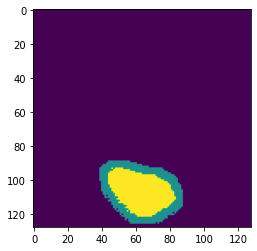

In [ ]:
printImg(getBorderImg(3, 6))

In [ ]:
def createModel():
    # state
    lastInit = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    # input layer
    inputLayer = layers.Input(shape=([allBounds["h"], allBounds["w"], 1]))
    # hidden layer
    hiddenLayer = layers.Conv2D(32, (3, 3), activation="relu")(inputLayer)
    hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    hiddenLayer = layers.Flatten()(hiddenLayer)
    hiddenLayer = layers.Dense(200, activation="relu")(hiddenLayer)
    # output layer
    outputLayer = layers.Dense(100, activation="sigmoid", kernel_initializer=lastInit)(hiddenLayer)
    outputLayer = outputLayer * 1
    model = tf.keras.Model(inputLayer, outputLayer)
    return model

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
def build_unet_model(inX, inY):
    # inputs
    inputs = layers.Input(shape=(inX, inY, 1))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [ ]:
unet_model = build_unet_model(128, 128)
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_19[0][0]']              
                                )                                                             

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [ ]:
imgD = np.load("{}/0_range/{}-{}-2_128.npy".format(dataPath, 80, 100))
imgD.shape

(680, 128, 128, 1)

In [ ]:
imgY = np.load("{}/0_range/{}-{}-3-y_128.npy".format(dataPath, 80, 100))
imgY.shape

(680, 128, 128, 1)

In [ ]:
res = unet_model.fit(imgD, imgY, epochs=10)

Epoch 1/10
22/22 [==============================] - 12s 570ms/step - loss: 0.2171 - accuracy: 0.9308
Epoch 2/10
22/22 [==============================] - 9s 421ms/step - loss: 0.1928 - accuracy: 0.9341
Epoch 3/10
22/22 [==============================] - 9s 422ms/step - loss: 0.1768 - accuracy: 0.9386
Epoch 4/10
22/22 [==============================] - 9s 423ms/step - loss: 0.1645 - accuracy: 0.9422
Epoch 5/10
22/22 [==============================] - 9s 423ms/step - loss: 0.1579 - accuracy: 0.9440
Epoch 6/10
22/22 [==============================] - 9s 426ms/step - loss: 0.1489 - accuracy: 0.9455
Epoch 7/10
22/22 [==============================] - 9s 429ms/step - loss: 0.1537 - accuracy: 0.9447
Epoch 8/10
22/22 [==============================] - 9s 429ms/step - loss: 0.1383 - accuracy: 0.9483
Epoch 9/10
22/22 [==============================] - 9s 431ms/step - loss: 0.1322 - accuracy: 0.9501
Epoch 10/10
22/22 [==============================] - 9s 431ms/step - loss: 0.1324 - accuracy: 0.950

In [ ]:
unet_model.load_weights("{}/0_range/model_{}-3_128".format(dataPath, 100))

In [ ]:
def getPred(dFrom, dTo, v):
    for i in range(128):
        for j in range(128):
            dTo[i][j][0] = dFrom[i][j][v]
def testModel(no, v):
    imgTest = imgD[no]
    imgTest = imgTest.reshape((1, 128, 128, 1))

    imgMask = imgY[no]
    imgMask = imgMask.reshape((128, 128))
    imgTestMask = unet_model.predict(imgTest)[0]
    # print(imgTestMask.shape)
    # return imgTestMask

    imgTestMask1 = np.array([0.0 for i in range(128 * 128)])
    imgTestMask1 = imgTestMask1.reshape((128, 128, 1))
    getPred(imgTestMask, imgTestMask1, v)
    imgTestMask1 = imgTestMask1.reshape((128, 128))
    plt.imshow(imgMask)
    plt.show()
    plt.imshow(imgTestMask1)
    plt.show()
    # plt.imshow(imgTestMask)
    # plt.show()
for i in range(100):
    testModel(i, 2)
# testModel(16, 1)
# testModel(16, 2)

In [ ]:
unet_model.save("{}/0_range/model_{}-3_128".format(dataPath, 100))

In [ ]:
def getPredY3(dFrom1, dFrom2, dFrom3, dTo):
    for i in range(128):
        for j in range(128):
            dTo[i][j][0] = dFrom1[i][j][0]
            dTo[i][j][1] = dFrom2[i][j][0]
            dTo[i][j][2] = dFrom3[i][j][0]
def getAllBorderYVals(noFrom, noTo):
    global dataPath
    imgs = [ ]
    for no in range(noFrom, noTo):
        for z in range(2, readImgBound(no)["depth"]):
            imgt = np.array(getImgBound(no, z - 2, False, -2000, 2000, 'dImg'))
            imgt = imgt.reshape((1, 128, 128, 1))
            imgTestMask = unet_model.predict(imgt)[0]
            imgTestMask1 = np.array([0.0 for i in range(128 * 128)])
            imgTestMask1 = imgTestMask1.reshape((128, 128, 1))
            getPred(imgTestMask, imgTestMask1, 2)
            imgTestMask1 = imgTestMask1.reshape((128, 128, 1))

            imgt = np.array(getImgBound(no, z - 1, False, -2000, 2000, 'dImg'))
            imgt = imgt.reshape((1, 128, 128, 1))
            imgTestMask = unet_model.predict(imgt)[0]
            imgTestMask2 = np.array([0.0 for i in range(128 * 128)])
            imgTestMask2 = imgTestMask2.reshape((128, 128, 1))
            getPred(imgTestMask, imgTestMask2, 2)
            imgTestMask2 = imgTestMask2.reshape((128, 128, 1))

            imgt = np.array(getImgBound(no, z, False, -2000, 2000, 'dImg'))
            imgt = imgt.reshape((128, 128, 1))
            imgTestMask3 = np.array([0.0 for i in range(128 * 128 * 3)])
            imgTestMask3 = imgTestMask3.reshape((128, 128, 3))
            getPredY3(imgTestMask1, imgTestMask2, imgt, imgTestMask3)
            imgs.append(imgTestMask3)
        print(no)
    imgs = np.array(imgs)
    # print(imgs.shape)
    imgs = imgs.reshape((imgs.shape[0], 128, 128, 3))
    np.save("{}/0_range/{}-{}-3-pred-layer2x3-y_128".format(dataPath, noFrom, noTo), imgs)
    return imgs
# def getAllBorderYVals(noFrom, noTo):
#     imgD2 = np.load("{}/0_range/{}-{}-2_128.npy".format(dataPath, noFrom, noTo))
#     imgs = [ ]
#     for i in range(imgD2.shape[0]):
#         imgTest = imgD2[i]
#         imgTest = imgTest.reshape((1, 128, 128, 1))
#         imgTestMask = unet_model.predict(imgTest)[0]

#         imgTestMask1 = np.array([0.0 for i in range(128 * 128)])
#         imgTestMask1 = imgTestMask1.reshape((128, 128, 1))
#         getPred(imgTestMask, imgTestMask1, 2)
#         imgTestMask1 = imgTestMask1.reshape((128, 128, 1))
#         imgs.append(imgTestMask1)
#     imgs = np.array(imgs)

#     # imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2], 1))
#     np.save("{}/0_range/{}-{}-3-pred-layer2-y_128".format(dataPath, noFrom, noTo), imgs)
#     return imgs
#     # return imgs

In [ ]:
imgYPred = getAllBorderYVals(80, 100)
imgYPred.shape

In [ ]:
imgYPred = np.load("{}/0_range/{}-{}-3-pred-layer2x3-y_128.npy".format(dataPath, 1, 11))
imgYPred.shape

(365, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


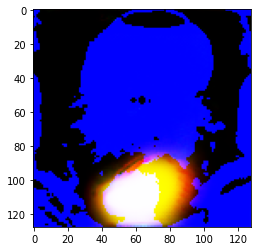

In [ ]:
plt.imshow(imgYPred[10])
plt.show()

In [ ]:
def build_unet_model(inX, inY):
    # inputs
    inputs = layers.Input(shape=(inX, inY, 3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [ ]:
unet_model2 = build_unet_model(128, 128)
unet_model2.summary()

In [ ]:
unet_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [ ]:
imgD = np.load("{}/0_range/{}-{}-3-pred-layer2x3-y_128.npy".format(dataPath, 80, 100))
imgD.shape

(640, 128, 128, 3)

In [ ]:
imgY = np.load("{}/0_range/{}-{}-skip-3-y_128.npy".format(dataPath, 80, 100))
imgY.shape

(640, 128, 128, 1)

In [ ]:
res = unet_model2.fit(imgD, imgY, epochs=10)

Epoch 1/10
20/20 [==============================] - 10s 438ms/step - loss: 0.1900 - accuracy: 0.9376
Epoch 2/10
20/20 [==============================] - 9s 440ms/step - loss: 0.1500 - accuracy: 0.9483
Epoch 3/10
20/20 [==============================] - 9s 440ms/step - loss: 0.1395 - accuracy: 0.9498
Epoch 4/10
20/20 [==============================] - 9s 442ms/step - loss: 0.1378 - accuracy: 0.9508
Epoch 5/10
20/20 [==============================] - 9s 443ms/step - loss: 0.1300 - accuracy: 0.9528
Epoch 6/10
20/20 [==============================] - 9s 445ms/step - loss: 0.1303 - accuracy: 0.9531
Epoch 7/10
20/20 [==============================] - 9s 444ms/step - loss: 0.1282 - accuracy: 0.9535
Epoch 8/10
20/20 [==============================] - 9s 445ms/step - loss: 0.1231 - accuracy: 0.9548
Epoch 9/10
20/20 [==============================] - 9s 447ms/step - loss: 0.1162 - accuracy: 0.9567
Epoch 10/10
20/20 [==============================] - 9s 447ms/step - loss: 0.1218 - accuracy: 0.954

In [ ]:
def getPred(dFrom, dTo, v):
    for i in range(128):
        for j in range(128):
            dTo[i][j][0] = dFrom[i][j][v]
def testModel(no, v):
    imgTest = imgD[no]
    imgTest = imgTest.reshape((1, 128, 128, 3))

    imgMask = imgY[no]
    imgMask = imgMask.reshape((128, 128))
    imgTestMask = unet_model2.predict(imgTest)[0]
    # print(imgTestMask.shape)
    # return imgTestMask

    imgTestMask1 = np.array([0.0 for i in range(128 * 128)])
    imgTestMask1 = imgTestMask1.reshape((128, 128, 1))
    getPred(imgTestMask, imgTestMask1, v)
    imgTestMask1 = imgTestMask1.reshape((128, 128))
    plt.imshow(imgMask)
    plt.show()
    # plt.imshow(imgTestMask1)
    # plt.show()
    plt.imshow(imgTestMask)
    plt.show()
for i in range(100):
    testModel(i, 2)
# testModel(10, 2)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
unet_model2.save("{}/0_range/model_{}-3x3-boundary-out_128".format(dataPath, 100))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/project2/data/nifti/0_range/model_100-3x3-boundary-out_128/assets


In [ ]:
def getPred(dFrom, dTo, v):
    for i in range(128):
        for j in range(128):
            dTo[i][j][0] = dFrom[i][j][v]
def testModel(no, v):
    imgTest = imgD[no]
    imgTest = imgTest.reshape((1, 128, 128, 3))

    imgMask = imgY[no]
    imgMask = imgMask.reshape((128, 128))
    imgTestMask = unet_model2.predict(imgTest)[0]
    # print(imgTestMask.shape)
    # return imgTestMask

    imgTestMask1 = np.array([0.0 for i in range(128 * 128)])
    imgTestMask1 = imgTestMask1.reshape((128, 128, 1))
    getPred(imgTestMask, imgTestMask1, v)
    imgTestMask1 = imgTestMask1.reshape((128, 128))
    plt.imshow(imgMask)
    plt.show()
    # plt.imshow(imgTestMask1)
    # plt.show()
    plt.imshow(imgTestMask)
    plt.show()
for i in range(100):
    testModel(i, 2)
# testModel(10, 2)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
imgD = np.load("{}/0_range/{}-{}-2_128.npy".format(dataPath, 80, 100))
imgD.shape

(680, 128, 128, 1)

In [ ]:
for i in range(100):
    printImg(imgD[i].reshape(128, 128))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
imgD2 = np.load("{}/0_range/{}-{}-3-pred-layer2x3-y_128.npy".format(dataPath, 80, 100))
imgD2.shape

(640, 128, 128, 3)

In [ ]:
for i in range(100):
    printImg(imgD2[i])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
imgD11 = np.load("{}/0_range/{}-{}-3-pred-layer2x3-y_128.npy".format(dataPath, 1, 11))
imgD12 = np.load("{}/0_range/{}-{}-3-pred-layer2x3-y_128.npy".format(dataPath, 11, 40))
imgD13 = np.load("{}/0_range/{}-{}-3-pred-layer2x3-y_128.npy".format(dataPath, 40, 80))
imgD14 = np.load("{}/0_range/{}-{}-3-pred-layer2x3-y_128.npy".format(dataPath, 80, 100))
imgD11.shape[0] + imgD12.shape[0] + imgD13.shape[0] + imgD14.shape[0]

3661